<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/vapnik2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
"""
Author: Fayyaz Minhas
Simple demonstration of learning with statistical predicates by Vapnik
"""


'\nAuthor: Fayyaz Minhas\nSimple demonstration of learning with statistical predicates by Vapnik\n'

In [9]:
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings
#nothing to see here - just a plotting function
def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None or len(conts)<2:
            #conts = list(classes)
            vmin,vmax = classes[0]-eps,classes[-1]+eps
        else:            
            vmin,vmax= np.min(conts)-eps,np.max(conts)+eps
        
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None or len(conts)<2:            
            conts = sorted([-1+eps,0,1-eps])
        else:
            vmin,vmax= np.min(conts)-eps,np.max(conts)+eps
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)
        
        z = np.reshape(z,(npts,npts)).T        
        
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)
    
    if Y is not None:        
        for i,y in enumerate(classes):
            
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 50)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()
    return extent

<ipython-input-9-5604fef99228>:63: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


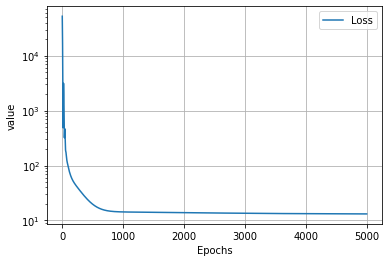

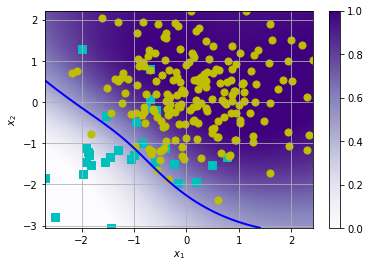

[-2.700724809315917, 2.402643142730158, -3.0587196692755185, 2.223110674491954]

In [60]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.modules as nn
import torch.optim as optim
from sklearn.datasets import make_moons, make_circles;  
#Let's generate some data
seed = 0
np.random.seed(seed=seed)
torch.manual_seed(seed)

#X,y = make_circles(n_samples=800,  shuffle=True, noise=0.05, random_state=seed, factor = 0.5); Xp = X[y==1]; Xn = X[y!=1]
Xp = 1.0+np.random.randn(200,2); Xn = -0.5-np.random.randn(30,2);
inputs = np.vstack((Xp,Xn))	
from sklearn.preprocessing import StandardScaler
inputs = StandardScaler().fit_transform(inputs)
#labels
targets = np.hstack((np.ones(len(Xp)),-0*np.ones(len(Xn))))
ttargets = targets+0 #copy of true labels
 
from sklearn.metrics.pairwise import rbf_kernel
#K = (np.dot(inputs,inputs.T)+1)**2
K = rbf_kernel(inputs,gamma=1.0)
K = torch.from_numpy(K).float() #kernel
psi2 = []
for k in range(inputs.shape[0]):
  r = inputs[k:k+1,:]
  psi2.append((r.T@r).flatten())
psi2 = np.array(psi2)
P2 = psi2@psi2.T #makes the psi(x)=x@x.T

P = (1*np.ones(K.shape)+1*inputs@inputs.T+P2)/3.0#psi(x)=1,psi(x)=x,psi(x)=x@x.T
P = torch.from_numpy(P).float() #kernel
M = 1*torch.eye(K.shape[0])+0*K+1*P #Learning with statistical invariants
#M = torch.eye(K.shape[0]) #No statistical invariants
device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
x = torch.from_numpy(inputs).float()
y = torch.from_numpy(targets).float()
N, D_in,D_out = x.shape[0], x.shape[1], 1

class Feedforward(torch.nn.Module):
        def __init__(self, layer_size):
            super(Feedforward, self).__init__()
            self.layer_size = layer_size            
            self.fc1 = torch.nn.Linear(self.layer_size[0], self.layer_size[1])
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.layer_size[1], self.layer_size[2])
            self.sigmoid = torch.nn.Sigmoid()
            self.tanh = torch.nn.Tanh()
            self.fc3 = torch.nn.Linear(self.layer_size[2], self.layer_size[-1])
        def forward(self, x):
            x = self.fc1(x)
            x = self.tanh(x)
            x = self.fc2(x)
            x = self.tanh(x)
            x = self.fc3(x)
            
            return x
model = Feedforward([D_in,500,200,D_out])

optimizer = optim.Adam(model.parameters(), lr=1e-4)

L = [] #history of losses
for epoch in range(5000):
      """
      # REPRESENTATION
      """
      y_pred = model(x).flatten()#x@wb+bb
      """
      # EVALUATION
      """
      obj = (y-y_pred)@M@(y-y_pred)
      """
      #OPTIMIZATION
      """    
      obj.backward()
      # Using built-in optimizer
      optimizer.step()
      optimizer.zero_grad()
      L.append(obj.detach().numpy()) #save for history and plotting

#plt.close("all")
plt.figure()
plt.plot(L);plt.yscale('log')

plt.grid(); plt.xlabel('Epochs'); plt.ylabel('value');plt.legend(['Loss','Objective'])

def clf(inputs): 
  return model(torch.from_numpy(inputs).float()).detach().numpy()#inputs@wbn+bbn

plt.figure()
plotit(inputs,targets,clf=clf,conts=[0.5])


In [11]:
#y_pred = x@wb+bb#wb@K
#berr = torch.mean(y_pred[uidx])-cratio
z = clf(inputs)
#print("Accuracy",np.mean(z*ttargets>0))
from sklearn.metrics import roc_auc_score
print("AUROC",roc_auc_score(ttargets, z))
#print("AUROC",roc_auc_score(ttargets, wbn))

AUROC 0.9925


In [12]:
inputs.T@z,inputs.T@ttargets

(array([[17.63204968],
        [19.53351413]]), array([17.63227685, 19.53598008]))

In [13]:
model

Feedforward(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)

In [14]:
y_pred.shape

torch.Size([210])

In [17]:
(inputs@inputs.T).shape

(210, 210)

In [50]:
psi2.shape

(210, 4)

In [52]:
psi2@psi2.T

array([[1.12249779e+01, 8.12275618e+00, 8.62681120e+00, ...,
        4.75318453e+01, 1.98001944e+01, 4.87947750e+01],
       [8.12275618e+00, 3.34733969e+01, 3.45356815e-02, ...,
        7.47836960e+01, 3.89896888e+01, 1.10659866e+02],
       [8.62681120e+00, 3.45356815e-02, 1.73567873e+01, ...,
        1.70498847e+01, 4.87983252e+00, 8.84651913e+00],
       ...,
       [4.75318453e+01, 7.47836960e+01, 1.70498847e+01, ...,
        2.71962622e+02, 1.25272920e+02, 3.29938204e+02],
       [1.98001944e+01, 3.89896888e+01, 4.87983252e+00, ...,
        1.25272920e+02, 5.94244333e+01, 1.59417546e+02],
       [4.87947750e+01, 1.10659866e+02, 8.84651913e+00, ...,
        3.29938204e+02, 1.59417546e+02, 4.32535048e+02]])